<a href="https://colab.research.google.com/github/Mizuki-OHASHI/notebooks/blob/main/reservoir_computing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# リザバーコンピューティングの実装

### リザバーコンピューティングとは

リザバーコンピューティング (Reservoir Computing) は、**時間的なデータの処理に適したニューラルネットワークの一種**です。特に、時系列予測や動的システムのモデリングに強みを持ちます。

この手法では、中間層（**リザバー**）にランダムに結線された多数のノードを用い、その重みは**訓練せず固定**のまま使用します。**学習が必要なのは出力層のみ**であるため、学習が非常に高速かつ軽量です。

### 主な特徴

- **軽量かつ高速な学習**：重みを更新するのは出力層のみ。
- **非線形時系列の処理に強い**：リザバー内の動的な振る舞いが、複雑な時系列パターンを表現可能にする。
- **リカレントニューラルネットワーク (RNN) の一種**：ただし学習の安定性や実装の容易さにおいて優位。
- **ハードウェア実装とも親和性が高い**：アナログ回路や物理システムをリザバーとして利用する研究もある。


In [ ]:
!pip install reservoirpy

  Using cached dill-0.4.0-py3-none-any.whl.metadata (10 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 208.8/208.8 kB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.7/119.7 kB 11.8 MB/s eta 0:00:00


### サンプルコードで動作確認

- pip のサンプルコードでエラーなく動くかどうか確認
- fetched from https://pypi.org/project/reservoirpy/


In [ ]:
from reservoirpy.datasets import mackey_glass, to_forecasting
from reservoirpy.nodes import Reservoir, Ridge
from reservoirpy.observables import rmse, rsquare

### Step 1: Load the dataset

X = mackey_glass(n_timesteps=2000)  # (2000, 1)-shaped array
# create y by shifting X, and train/test split
x_train, x_test, y_train, y_test = to_forecasting(X, test_size=0.2)

### Step 2: Create an Echo State Network

# 100 neurons reservoir, spectral radius = 1.25, leak rate = 0.3
reservoir = Reservoir(units=100, sr=1.25, lr=0.3)
# feed-forward layer of neurons, trained with L2-regularization
readout = Ridge(ridge=1e-5)
# connect the two nodes
esn = reservoir >> readout

### Step 3: Fit, run and evaluate the ESN

esn.fit(x_train, y_train, warmup=100)
predictions = esn.run(x_test)

print(f"RMSE: {rmse(y_test, predictions)}; R^2 score: {rsquare(y_test, predictions)}")
# RMSE: 0.0020282; R^2 score: 0.99992

Running Model-0:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-0: 487it [00:00, 4866.25it/s]           
Running Model-0: 974it [00:00, 3473.07it/s]
Running Model-0: 1599it [00:00, 3787.70it/s]
Running Model-0: 100%|██████████| 1/1 [00:00<00:00,  2.26it/s]


Fitting node Ridge-0...


Running Model-0: 400it [00:00, 6530.36it/s]           

RMSE: 0.0025013116442207848; R^2 score: 0.9998728929224348


### 記事の再現 (東京の気温)

- 東京の気温を題材としたQiitaの実装例「リザバーコンピューティング概観」を再現してみる
- fetched from https://qiita.com/masaka_programming/items/4ce659f5e093ede9a0a4

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
%matplotlib inline

In [ ]:
# データセットのダウンロードと可視化
data_src = "https://www.salesanalytics.co.jp/5kf2"
X_df = pd.read_csv(data_src, index_col=0)

======================== データの確認 ========================


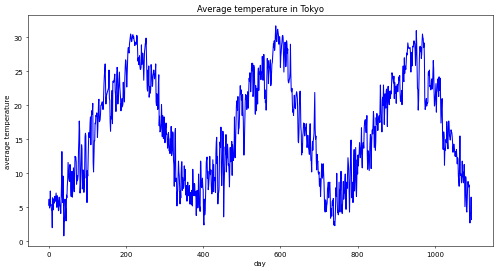

[(765, 1), (765, 1), (327, 1), (327, 1)]


Running Model-157:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-157: 765it [00:00, 4221.63it/s]
Running Model-157: 100%|██████████| 1/1 [00:00<00:00,  5.25it/s]


Fitting node Ridge-157...


Running Model-157: 327it [00:00, 4275.49it/s]           


======================== 予測結果 ========================


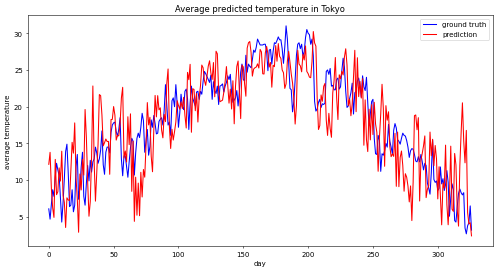

In [ ]:
X = np.array(X_df.values)
fig = plt.figure(figsize=(12, 6), dpi=50)
ax = plt.axes()
ax.plot(X, "b-")
ax.set_xlabel("day")
ax.set_ylabel("average temperature")
ax.set_title("Average temperature in Tokyo")
print("="*24+" データの確認 "+"="*24)
plt.show()

# 訓練データとテストデータの作成

# 前半7割を訓練用、後半3割をテスト用に使う
train = X[:int(len(X)*0.7)]
test = X[int(len(X)*0.7):]
# N日後の平均気温を目標値とする
N = 2
x_train = train[:-N]
y_train = train[N:]
x_test = test[:-N]
y_test = test[N:]

print(list(arr.shape for arr in [x_train, y_train, x_test, y_test]))

# ESNモデルの訓練
# easyesn がインストールできず, 他のパッケージを使うことにしたので, ここが Qiita の記事と違うところ

# 100 neurons reservoir, spectral radius = 1.25, leak rate = 0.3
reservoir = Reservoir(units=100, sr=15, lr=0.75, seed=42) # sr は入出力のスケールと同程度にするとよさそう
# feed-forward layer of neurons, trained with L2-regularization (リッジ回帰)
readout = Ridge(ridge=1e-5)
# connect the two nodes
esn = reservoir >> readout

esn.fit(x_train, y_train, warmup=365) # warmup は周期と同じにすることが多いらしい

# 予測結果
y_test_pred = esn.run(x_test)

fig = plt.figure(figsize=(12, 6), dpi=50)
ax = plt.axes()
ax.plot(y_test, "b-", label="ground truth")
ax.plot(y_test_pred, "r-", label="prediction")
ax.set_xlabel("day")
ax.set_ylabel("average temperature")
ax.set_title("Average predicted temperature in Tokyo")
ax.legend()
print("="*24+" 予測結果 "+"="*24)
plt.show()

### 他のデータセットでやってみる (CO$_2$濃度)

- Mauna Loa Weekly Atmospheric CO2 Data
- データの説明: https://arc.net/l/quote/bblnxrtn

In [250]:
from sklearn.datasets import fetch_openml

co2 = fetch_openml(data_id=41187, as_frame=True)
co2.frame.head()

,year,month,day,weight,flag,station,co2
0,1958,3,29,4,0,MLO,316.1
1,1958,4,5,6,0,MLO,317.3
2,1958,4,12,4,0,MLO,317.6
3,1958,4,19,6,0,MLO,317.5
4,1958,4,26,2,0,MLO,316.4


In [251]:
import polars as pl

co2_data = pl.DataFrame(co2.frame[["year", "month", "day", "co2"]]).select(
    pl.date("year", "month", "day"), "co2"
)
co2_data.head()

date,co2
date,f64
1958-03-29,316.1
1958-04-05,317.3
1958-04-12,317.6
1958-04-19,317.5
1958-04-26,316.4


[(2225, 1), (2173, 1)]
======================== データの確認 ========================


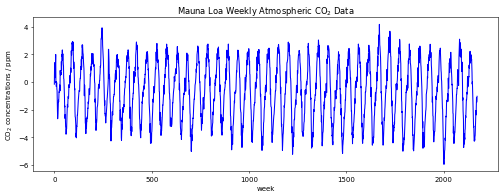

[(1519, 1), (1519, 1), (650, 1), (650, 1)]


Running Model-175:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-175: 415it [00:00, 4143.02it/s]           
Running Model-175: 831it [00:00, 4123.60it/s]
Running Model-175: 1519it [00:00, 3996.92it/s]
Running Model-175: 100%|██████████| 1/1 [00:00<00:00,  2.47it/s]


Fitting node Ridge-175...


Running Model-175: 650it [00:00, 3497.76it/s]


======================== 予測結果 ========================


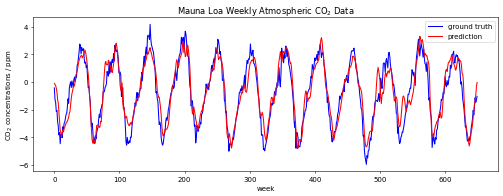

In [281]:
X_co2 = co2_data["co2"].to_numpy().reshape((-1, 1))
# 1ずつずらしながら 365//7 要素の平均をとる
X_co2_trend = np.array([X_co2[i:i+365//7].mean() for i in range(len(X_co2)-365//7)]).reshape((-1, 1))
print(list(arr.shape for arr in [X_co2, X_co2_trend]))
# X_co2 = np.concatenate([ X_co2_trend, X_co2[:len(X_co2)-365//7]-X_co2_trend], axis=1)
X_co2 = X_co2[:len(X_co2)-365//7]-X_co2_trend # トレンド成分の削除

fig = plt.figure(figsize=(12, 4), dpi=50)
ax = plt.axes()
ax.plot(X_co2, "b-")
ax.set_xlabel("week")
ax.set_ylabel("CO$_2$ concentrations / ppm")
ax.set_title("Mauna Loa Weekly Atmospheric CO$_2$ Data")
print("="*24+" データの確認 "+"="*24)
plt.show()

# 訓練データとテストデータの作成

# 前半7割を訓練用、後半3割をテスト用に使う
train = X_co2[:int(len(X_co2)*0.7)]
test = X_co2[int(len(X_co2)*0.7):]
# N週後の平均濃度を目標値とする
N = 2
x_train = train[:-N]
y_train = train[N:]
x_test = test[:-N]
y_test = test[N:]

print(list(arr.shape for arr in [x_train, y_train, x_test, y_test]))

# ESNモデルの訓練

# 100 neurons reservoir, spectral radius = 1.25, leak rate = 0.3
reservoir = Reservoir(units=100, sr=5, lr=0.3, seed=42) # sr は入出力のスケールと同程度にするとよさそう
# feed-forward layer of neurons, trained with L2-regularization (リッジ回帰)
readout = Ridge(ridge=1e-3)
# connect the two nodes
esn = reservoir >> readout

esn.fit(x_train, y_train, warmup=365//7) # warmup は周期と同じにすることが多いらしい

# 予測結果
y_test_pred = esn.run(x_test)

fig = plt.figure(figsize=(12, 4), dpi=50)
ax = plt.axes()
ax.plot(y_test, "b-", label="ground truth")
ax.plot(y_test_pred, "r-", label="prediction")
ax.set_xlabel("week")
ax.set_ylabel("CO$_2$ concentrations / ppm")
ax.set_title("Mauna Loa Weekly Atmospheric CO$_2$ Data")
ax.legend()
print("="*24+" 予測結果 "+"="*24)
plt.show()

### 2次元データでやってみる (動物の軌跡)

- Animal tracking data set
- fetched from https://www.kaggle.com/datasets/frasonfrancis/animal-tracking-data-set


In [286]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [303]:
path = "/content/drive/MyDrive/Colab Notebooks/data/Animal tracking data set.csv"
df = pd.read_csv(path)
df.head()

,event-id,visible,timestamp,location-long,location-lat,argos:altitude,argos:best-level,argos:calcul-freq,argos:iq,argos:lat1,...,argos:sensor-1,argos:sensor-2,argos:sensor-3,argos:sensor-4,argos:valid-location-algorithm,sensor-type,individual-taxon-canonical-name,tag-local-identifier,individual-local-identifier,study-name
0,1079380974,True,2009-05-27 13:16:31.000,24.138,61.122,111.0,-133.0,401.675359,0,61.122,...,8,15,120,0,1.0,argos-doppler-shift,Larus fuscus,91732,91732A,Navigation experiments in lesser black-backed ...
1,1079380975,True,2009-05-27 13:26:58.000,NaN,NaN,0.0,-129.0,401.650000,0,NaN,...,8,13,120,0,NaN,argos-doppler-shift,Larus fuscus,91732,91732A,Navigation experiments in lesser black-backed ...
2,1079380976,True,2009-05-27 13:49:50.000,NaN,NaN,0.0,-130.0,401.675359,0,NaN,...,8,23,120,0,NaN,argos-doppler-shift,Larus fuscus,91732,91732A,Navigation experiments in lesser black-backed ...
3,1079380977,True,2009-05-27 14:54:07.000,24.652,61.258,0.0,-121.0,401.675359,30,61.258,...,8,17,112,0,1.0,argos-doppler-shift,Larus fuscus,91732,91732A,Navigation experiments in lesser black-backed ...
4,1079380978,True,2009-05-27 15:05:03.000,24.604,61.240,0.0,-122.0,401.675381,60,56.581,...,8,19,112,0,2.0,argos-doppler-shift,Larus fuscus,91732,91732A,Navigation experiments in lesser black-backed ...


In [304]:
df = df[["timestamp", "location-long", "location-lat"]]
df['timestamp'] = pd.to_datetime(df["timestamp"])
df_hour = df.resample("1h", on="timestamp").mean()
df_hour.head()

<ipython-input-304-c137eb8ef5c8>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['timestamp'] = pd.to_datetime(df["timestamp"])


,location-long,location-lat
timestamp,,
2009-05-25 00:00:00,24.121667,61.277667
2009-05-25 01:00:00,NaN,NaN
2009-05-25 02:00:00,NaN,NaN
2009-05-25 03:00:00,NaN,NaN
2009-05-25 04:00:00,NaN,NaN


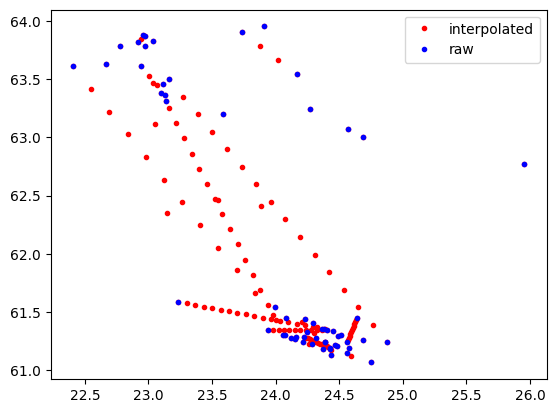

In [318]:
df_hour_lin_inter = df_hour.interpolate()
plt.plot(df_hour_lin_inter["location-long"][:24*7], df_hour_lin_inter["location-lat"][:24*7], "r.", label="interpolated")
plt.plot(df_hour["location-long"][:24*7], df_hour["location-lat"][:24*7], "b.", label="raw")
plt.legend()
plt.show()

[(6998, 2), (6998, 2), (2998, 2), (2998, 2)]


Running Model-198:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-198: 355it [00:00, 3547.75it/s]           
Running Model-198: 748it [00:00, 3768.38it/s]
Running Model-198: 1234it [00:00, 4263.81it/s]
Running Model-198: 1755it [00:00, 4635.37it/s]
Running Model-198: 2258it [00:00, 4775.37it/s]
Running Model-198: 2825it [00:00, 5077.66it/s]
Running Model-198: 3409it [00:00, 5325.35it/s]
Running Model-198: 4005it [00:00, 5524.77it/s]
Running Model-198: 4558it [00:00, 5516.50it/s]
Running Model-198: 5110it [00:01, 5298.04it/s]
Running Model-198: 5668it [00:01, 5380.56it/s]
Running Model-198: 6248it [00:01, 5504.43it/s]
Running Model-198: 6998it [00:01, 5162.62it/s]
Running Model-198: 100%|██████████| 1/1 [00:01<00:00,  1.37s/it]


Fitting node Ridge-198...


Running Model-198: 2998it [00:00, 5486.72it/s]


======================== 予測結果 ========================


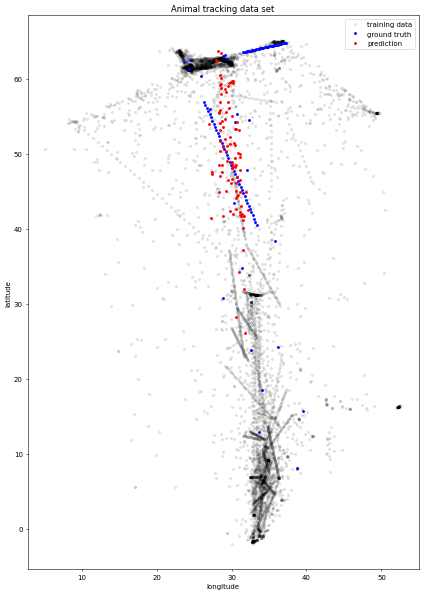

In [343]:
M = 10000 # 使用するデータ数 (全部使うと多すぎて学習に時間がかかるため)
X_ani = np.array(df_hour_lin_inter[["location-long", "location-lat"]])[:M, :]

# 訓練データとテストデータの作成

# 前半7割を訓練用、後半3割をテスト用に使う
train = X_ani[:int(len(X_ani)*0.7)]
test = X_ani[int(len(X_ani)*0.7):]
# N時間後の座標を目標値とする
N = 2
x_train = train[:-N]
y_train = train[N:]
x_test = test[:-N]
y_test = test[N:]

print(list(arr.shape for arr in [x_train, y_train, x_test, y_test]))
# -> [(38489, 2), (38489, 2), (16495, 2), (16495, 2)]

# ESNモデルの訓練

# 100 neurons reservoir, spectral radius = 1.25, leak rate = 0.3
reservoir = Reservoir(units=100, sr=25, lr=0.3, seed=42) # sr は入出力のスケールと同程度にするとよさそう
# feed-forward layer of neurons, trained with L2-regularization (リッジ回帰)
readout = Ridge(ridge=1e-3)
# connect the two nodes
esn = reservoir >> readout

esn.fit(x_train, y_train, warmup=24*7) # warmup は周期と同じにすることが多いらしい

# 予測結果
y_test_pred = esn.run(x_test)

fig = plt.figure(figsize=(12, 12), dpi=50)
ax = plt.axes()
ax.set_aspect("equal")
start = -100
end = -1
ax.plot(y_train[:, 0], y_train[:, 1], ".", color=(0,0,0,0.1), label="training data")
ax.plot(y_test[start:end,0], y_test[start:end,1], "b.", label="ground truth")
ax.plot(y_test_pred[start:end,0], y_test_pred[start:end,1], "r.", label="prediction")
ax.set_xlabel("longitude")
ax.set_ylabel("latitude")
ax.set_title("Animal tracking data set")
ax.legend()
fig.tight_layout()
# plt.savefig("/content/drive/MyDrive/Colab Notebooks/figures/Animal tracking data set_v2.svg")
print("="*24+" 予測結果 "+"="*24)
plt.show()

**凡例**
- 黒→訓練データ（スケール感を示すために一応プロット）
- 青→正解
- 赤→予測

**注意・コメント**
- 元のデータを線形補間して使っているのでところどころ直線的になっています。
- 7,000点で学習していますが2秒で終わりました (速いのはやっぱりいい)。
- ピッタリあっているとは言えないけど、今後頑張ったら軌跡の予測ができるようになりそう、くらいの所感です。